In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

BUILD_DATA = True
print('done')

done


In [ ]:
np.random.seed(1)

class DataBuilder():
    IMG_DIR = 'training-data/gaussian/images'
    IMG_SIZE = 200  # 200x200
    PARAM_DIR = 'training-data/gaussian/parameters.csv'
    data = []
    data_count = 0
    
    def open_data(self):
        params_df = pd.read_csv(self.PARAM_DIR)
        
        for file in tqdm(os.listdir(self.IMG_DIR)):
            try:
                # load image
                path = os.path.join(self.IMG_DIR, file)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))

                # load param for the image
                param = params_df.loc[params_df['file_name'] == file] # get params with that file name
                param = param.drop(columns=['file_name']) # drops filename column

                # adding to data
                self.data.append([np.array(img), param.to_numpy()])
                self.data_count += 1
            except Exception as e:
                print(str(e))
            
        assert self.data_count == 6000
        np.random.shuffle(self.data)
        np.save('data.npy', self.data)
        print(f'count: {self.data_count}')
        

        
if BUILD_DATA:
    hairnetdata = DataBuilder()
    hairnetdata.open_data()
    BUILD_DATA = False


In [2]:
data = np.load('data.npy', allow_pickle=True)

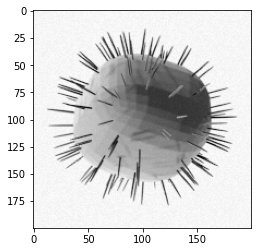

In [3]:
import matplotlib.pyplot as plt

plt.imshow(data[0][0], cmap='gray')
plt.show()

In [4]:
data[0][1]

array([[1.44409839e+00, 1.44288512e+00, 1.12510551e+00, 4.10701889e+00,
        5.55901606e-01, 1.76535150e-02, 3.89962620e+00, 1.46000000e+02,
        2.46806958e-01]])

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [6]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [7]:
class HairNet1(nn.Module):
    def __init__(self):
        super().__init__()
        # conv layers
        self.conv1 = nn.Conv2d(1, 32, 10, 1)
        self.conv2 = nn.Conv2d(32, 64, 10, 1)
        self.conv3 = nn.Conv2d(64, 128, 10, 1)
        
        x = torch.rand(200, 200).view(-1,1,200,200)
        self._lin_shape = None
        self._conv_pass(x)
        
        self.fc1 = nn.Linear(self._lin_shape, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 9) # we need 9 parameters
        
    def _conv_pass(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        if self._lin_shape is None:
            self._lin_shape = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
        
    def forward(self, x):
        x = self._conv_pass(x)
        x = x.view(-1, self._lin_shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

    
net = HairNet1()

In [8]:
import torch.optim as optim
# optimizer = optim.Adam(net.parameters(), lr=0.001)
# loss_func = nn.MSELoss()

imgs = torch.Tensor([d[0] for d in data])
imgs /= 255.0 # to get pixel values on [0, 1]
params = torch.Tensor([d[1] for d in data])

test_size = len(imgs) // 10  # 1/10 of all data

# Spliting data into training and testing
test_imgs = imgs[-test_size:]
test_params = params[-test_size:]

train_imgs = imgs[:-test_size]
train_params = params[:-test_size]

assert len(test_imgs) == len(test_params)
assert len(train_imgs) == len(train_params)

print(len(test_imgs))
print(len(train_imgs))

600
5400


In [9]:
# forward pass (used for train OR test)

model_loss_func = nn.MSELoss()  # loss function for training
simple_loss_func = nn.L1Loss()  # loss function for analysis

def fwd_pass(model, optimizer, imgs, params, train=False):
    if train:
        model.zero_grad()
        
    outs = model(imgs)
    model_loss = model_loss_func(outs.view(-1,1,9), params)
    simple_loss = simple_loss_func(outs.view(-1,1,9), params)
    
    if train:
        model_loss.backward()
        optimizer.step()
        
    return model_loss, simple_loss


In [10]:
def test(model, size=32):
    # sample without replacement:
    index = random.sample(range(len(test_imgs)), size)
    index = torch.tensor(index)
    
    batch_imgs = test_imgs[index]
    batch_params = test_params[index]
    with torch.no_grad():
        m_loss, s_loss = fwd_pass(model, None, batch_imgs.view(-1, 1, 200, 200).to(device), batch_params.view(-1, 1, 9).to(device))
    return m_loss, s_loss
    

In [11]:
moodel = HairNet1().to(device)
optimizer = optim.Adam(moodel.parameters(), lr=0.001)

# untrained
m_loss, s_loss = test(moodel, size=10)
print(m_loss, s_loss)

tensor(3081.6917) tensor(19.5461)


In [33]:
MODEL_NAME = 'HairNet1'

try:
    os.mkdir('models')
except Exception as e:
    # incase because dir exists
    pass
    
def train(model, name, optimizer):
    BATCH_SIZE = 4
    EPOCHS = 75  # the best will be selected before overfit
    
    try:
        os.mkdir(f'models/{name}')
    except Exception as e:
        # incase dir exists
        pass
    
    with open(f'models/{name}/{name}.log', 'a') as file:
        file.write(f'epoch,step,train_m_loss,train_s_loss,test_m_loss,test_s_loss')
        
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_imgs), BATCH_SIZE)):
                batch_imgs = train_imgs[i:i+BATCH_SIZE].view(-1,1,200,200).to(device)
                batch_params = train_params[i:i+BATCH_SIZE].to(device)
                
                train_m_loss, train_s_loss = fwd_pass(model, optimizer, batch_imgs, batch_params, train=True)
                
                # test every 9 steps; 6 times per epoch
                if i % 9 == 0:
                    test_m_loss, test_s_loss = test(model, size=100)
                    
                    # logging model progress:
                    file.write(f'{epoch},{i},{round(float(train_m_loss),4)},{round(float(train_s_loss),4)},{round(float(test_m_loss),4)},{round(float(test_s_loss),4)}')
                    
            # saving model every epoch
            pt_file_path = f'models/{name}/e{epoch}.pt'
            torch.save(model.state_dict(), f'models/{name}/e{epoch}.pt')
                
    

In [34]:
train(moodel, 'moodel', optimizer)

  0%|          | 6/1350 [00:14<52:32,  2.35s/it]  


KeyboardInterrupt: 

In [35]:
class HairNet2(nn.Module):
    def __init__(self):
        super().__init__()
        # conv layers
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        
        x = torch.rand(200, 200).view(-1,1,200,200)
        self._lin_shape = None
        self._conv_pass(x)
        
        self.fc1 = nn.Linear(self._lin_shape, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 9) # we need 9 parameters
        
    def _conv_pass(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        if self._lin_shape is None:
            self._lin_shape = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
        
    def forward(self, x):
        x = self._conv_pass(x)
        x = x.view(-1, self._lin_shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x
    
net = HairNet2()

In [39]:
class HairNet3(nn.Module):
    def __init__(self):
        super().__init__()
        # conv layers
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.conv3 = nn.Conv2d(64, 64, 5, 1)
        self.conv4 = nn.Conv2d(64, 64, 5, 1)
        
        x = torch.rand(200, 200).view(-1,1,200,200)
        self._lin_shape = None
        self._conv_pass(x)
        
        self.fc1 = nn.Linear(self._lin_shape, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 9) # we need 9 parameters
        
    def _conv_pass(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        
        if self._lin_shape is None:
            self._lin_shape = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
        
    def forward(self, x):
        x = self._conv_pass(x)
        x = x.view(-1, self._lin_shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        return x
    
net = HairNet3()